# Performs (multivariate) Dynamic Time Wrapping to check the similarites between the time 

In [52]:
import pandas as pd
from tslearn.metrics import dtw
from sklearn.manifold import TSNE, MDS
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.spatial import Voronoi
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, AgglomerativeClustering
from tqdm.notebook import tqdm

In [53]:
battery_paths = 'processed_datasets/All_Data_linear_C.csv'
df = pd.read_csv(battery_paths)

dfs_dict = {}

# For each battery in the dataset, create a dataframe and add it to the dictionary
for bat in df['battery_name'].unique():
    dfs_dict[bat] = df.query('battery_name == @bat')

# For each dfs drop the colums comment, type, battery_name, dateTime, endTime, timeRange, gt, cycle, capacity (Ah), soh and soh_interpolated
col_drop = ['comment', 'type', 'battery_name', 'dateTime', 'endTime', 'timeRange', 'gt', 'cycle', 'capacity (Ah)', 'soh', 'soh_interpolated', 'maxVoltage']
dfs_dict = {bat: df.drop(col_drop, axis=1) for bat, df in dfs_dict.items()}
# Normalize the dfs columns
dfs_dict = {bat: (df - df.mean()) / df.std() for bat, df in dfs_dict.items()}

# Use dtw to compute the distance between the dictorionary of batteries as a similarity matrix also use tqdm to track the time

# Check if distance matrix already exists
try:
    distances = np.load('distance_matrix.npy')
except:
    distances = np.zeros((len(dfs_dict), len(dfs_dict)))
    for i, (bat1, df1) in tqdm(enumerate(dfs_dict.items())):
        for j, (bat2, df2) in enumerate(dfs_dict.items()):
            distances[i, j] = dtw(df1.values, df2.values)
    # Save distance matrix to save time in the future
    np.save('distance_matrix.npy', distances)

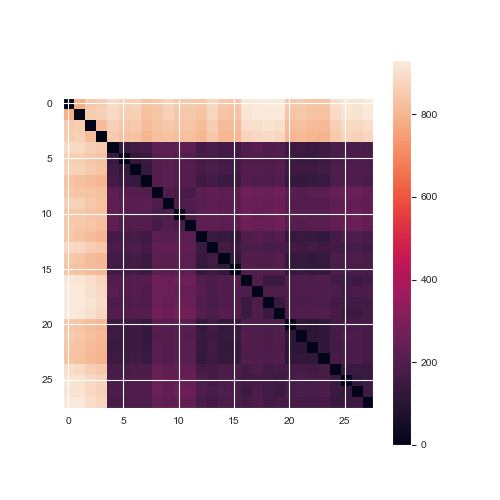

(28, 28)

In [54]:
# visualize the similarity matrix
plt.figure(figsize=(5, 5))
plt.imshow(distances)
plt.colorbar()
plt.show()

# Check if the matrix is has nan values
distances.shape

In [55]:
# Perfrom k-means clustering on the distance matrix
CLUSTERING = 'kmeans'
# CLUSTERING = 'AffinityPropagation'

def clustering(distances, method='kmeans'):
    if method == 'kmeans':
        N_CLUSTERS = 7
        k_means = KMeans(n_clusters=N_CLUSTERS, random_state=3).fit(distances)
        k_means_labels = k_means.labels_
        centroids = k_means.cluster_centers_
    elif method == 'DBSCAN':
        clustering = DBSCAN(eps=0.3, min_samples=2).fit(distances)
        k_means_labels = clustering.labels_
        N_CLUSTERS = len(set(k_means_labels))
        centroids = np.zeros((N_CLUSTERS, distances.shape[1]))
        for i in range(N_CLUSTERS):
            centroids[i] = np.mean(distances[k_means_labels == i], axis=0)
    elif method == 'AffinityPropagation':
        clustering = AffinityPropagation().fit(distances)
        k_means_labels = clustering.labels_
        N_CLUSTERS = len(set(k_means_labels))
        centroids = np.zeros((N_CLUSTERS, distances.shape[1]))
        for i in range(N_CLUSTERS):
            centroids[i] = np.mean(distances[k_means_labels == i], axis=0)

    return k_means_labels, centroids

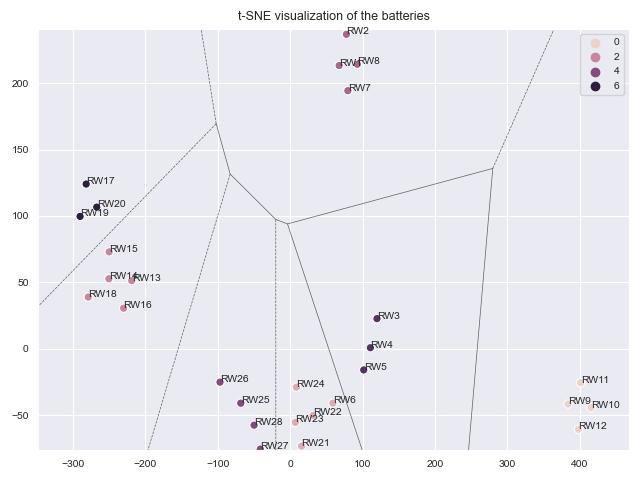

In [56]:
%matplotlib widget

# Reduce the dimensionality of the distance matrix using t-SNE
tsne = TSNE(n_components=2, perplexity=4)
tsne_distances = tsne.fit_transform(distances)

# Visualize the t-SNE distances with sns

# Add k-means centroids to the plot
k_means_labels, centroids = clustering(tsne_distances, method=CLUSTERING)

# Plot the Voronoi diagram
vor = Voronoi(centroids)
voronoi_plot_2d(vor, alpha=0.5, show_vertices=False, show_points=False, line_colors='black', line_width=0.5, line_alpha=0.6)

sns.set_style('darkgrid')
plt.title('t-SNE visualization of the batteries')

sns.scatterplot(x=tsne_distances[:, 0], y=tsne_distances[:, 1], hue=k_means_labels)
# add labels to the scatter plot
for i, bat in enumerate(dfs_dict.keys()):
    plt.annotate(bat, (tsne_distances[i, 0], tsne_distances[i, 1]))
    # Make annotation a bit smaller to avoid overlap with the points
    plt.rcParams.update({'font.size': 7.5})

plt.tight_layout()
plt.show()



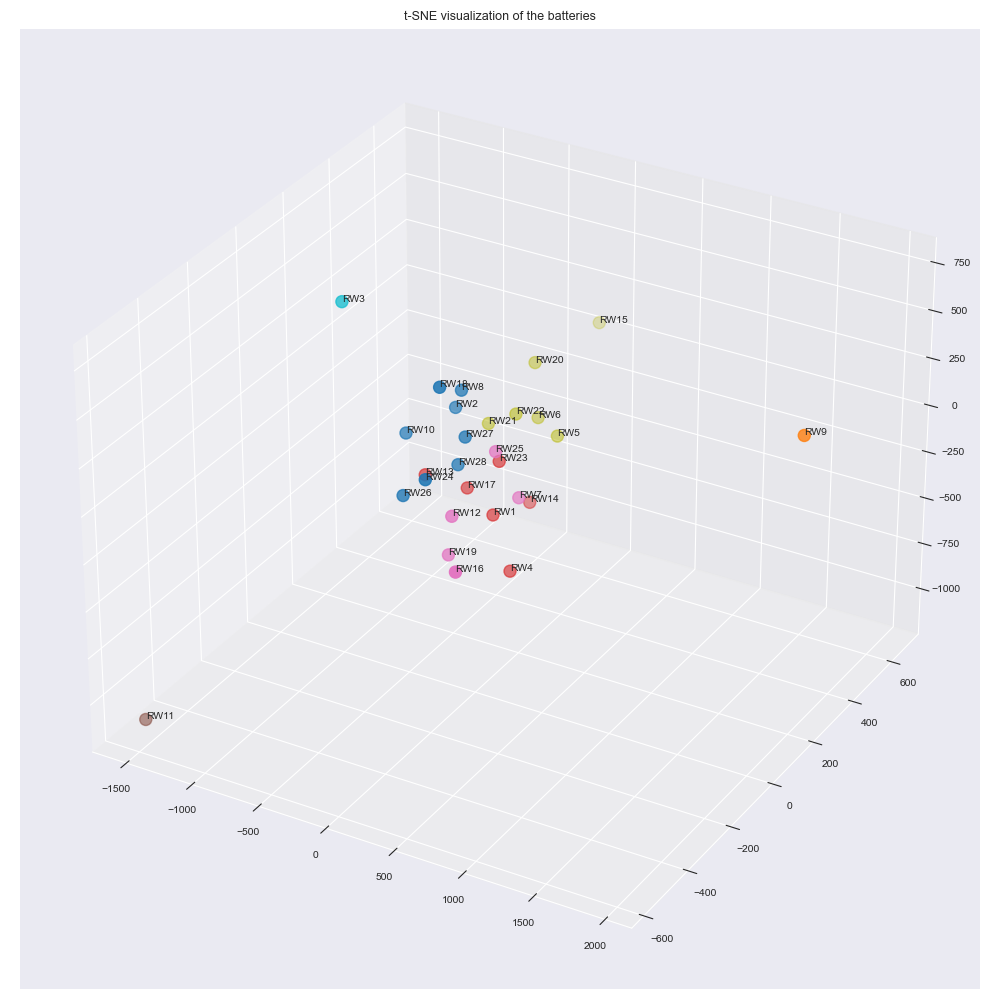

In [57]:
%matplotlib widget

# Use t-SNE to reduce the dimensionality of the distance matrix, but to 3-dimensions
tsne = TSNE(n_components=3, perplexity=4)
tsne_distances = tsne.fit_transform(distances)

# Visualize the t-SNE distances for a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('t-SNE visualization of the batteries')

# Add k-means centroids to the plot
k_means_labels, centroids = clustering(tsne_distances, method=CLUSTERING)

ax.scatter(tsne_distances[:, 0], tsne_distances[:, 1], tsne_distances[:, 2], c=k_means_labels, cmap='tab10', s=75)
# add labels to the scatter plot
for i, bat in enumerate(dfs_dict.keys()):
    ax.text(tsne_distances[i, 0], tsne_distances[i, 1], tsne_distances[i, 2], bat)
    # Make annotation a bit smaller to avoid overlap with the points
    plt.rcParams.update({'font.size': 7.5})

plt.tight_layout()
plt.show()



c:\Users\anton\anaconda3\envs\DD2424_env\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


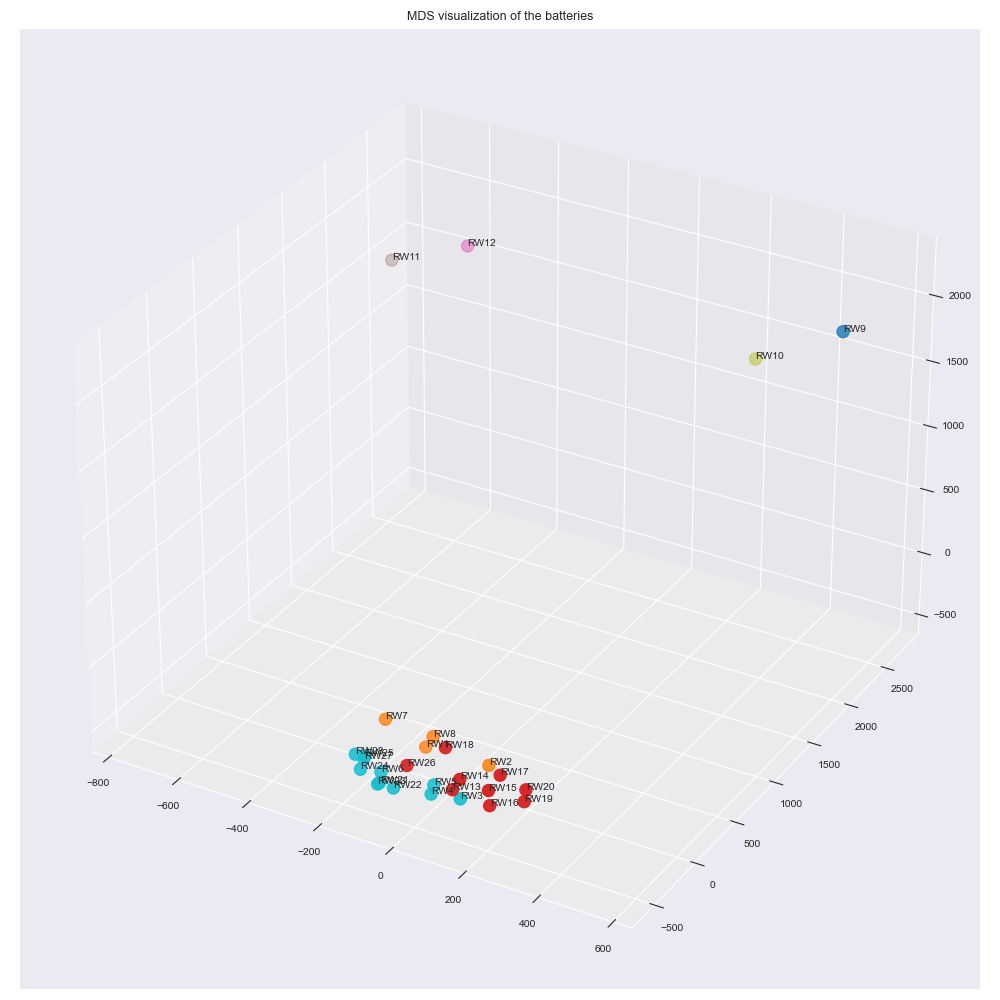

In [58]:
# Use t-SNE to reduce the dimensionality of the distance matrix, but to 3-dimensions
mds = MDS(n_components=3)
mds_distances = mds.fit_transform(distances)

# Visualize the t-SNE distances for a 3D plot that is interactive
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('MDS visualization of the batteries')

# Add k-means centroids to the plot
k_means_labels, centroids = clustering(mds_distances, method=CLUSTERING)

ax.scatter(mds_distances[:, 0], mds_distances[:, 1], mds_distances[:, 2], c=k_means_labels, cmap='tab10', s=75)
# add labels to the scatter plot
for i, bat in enumerate(dfs_dict.keys()):
    ax.text(mds_distances[i, 0], mds_distances[i, 1], mds_distances[i, 2], bat)
    # Make annotation a bit smaller to avoid overlap with the points
    plt.rcParams.update({'font.size': 7.5})

plt.tight_layout()
plt.show()

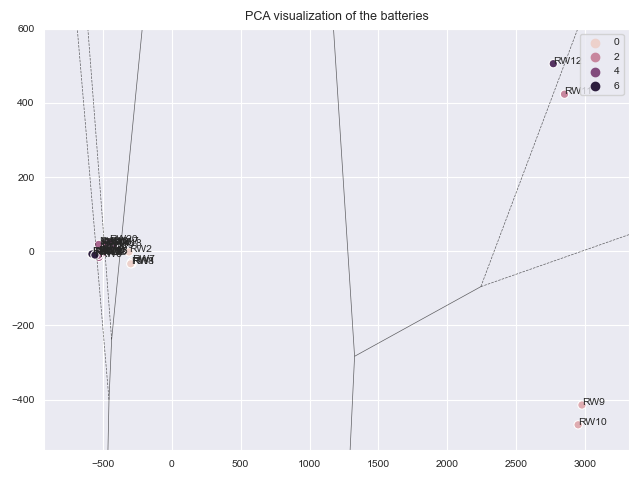

In [59]:
# Now the same but but with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_distances = pca.fit_transform(distances)


# Add k-means centroids to the plot
k_means_labels, centroids = clustering(pca_distances, method=CLUSTERING)

vor = Voronoi(centroids)
voronoi_plot_2d(vor, alpha=0.5, show_vertices=False, show_points=False, line_colors='black', line_width=0.5, line_alpha=0.6)

# Visualize the PCA distances with sns
sns.set_style('darkgrid')
plt.title('PCA visualization of the batteries')

sns.scatterplot(x=pca_distances[:, 0], y=pca_distances[:, 1], hue=k_means_labels)
# add labels to the scatter plot
for i, bat in enumerate(dfs_dict.keys()):
    plt.annotate(bat, (pca_distances[i, 0], pca_distances[i, 1]))
    plt.rcParams.update({'font.size': 7.5})

plt.tight_layout()
plt.show()

c:\Users\anton\anaconda3\envs\DD2424_env\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


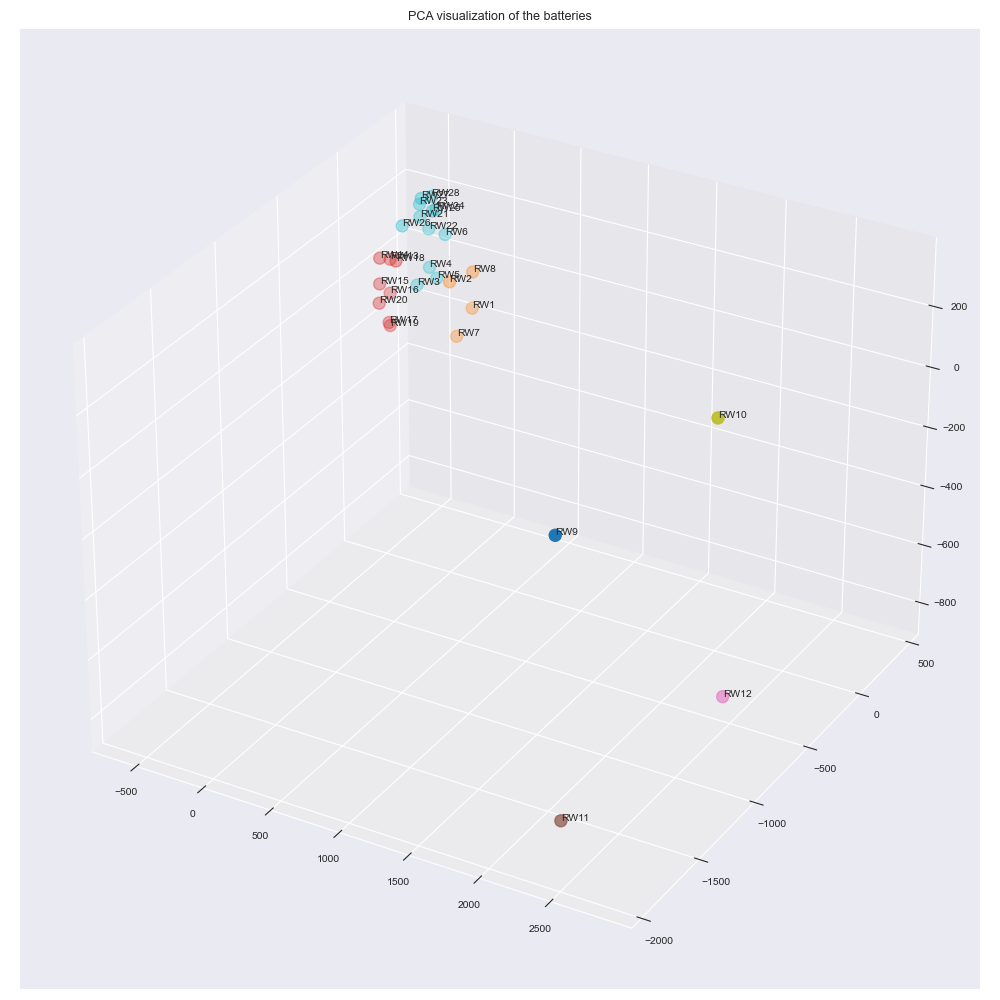

In [60]:
# Use t-SNE to reduce the dimensionality of the distance matrix, but to 3-dimensions
pca = PCA(n_components=3)
pca_distances = mds.fit_transform(distances)

# Visualize the t-SNE distances for a 3D plot that is interactive
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('PCA visualization of the batteries')

# Add k-means centroids to the plot
k_means_labels, centroids = clustering(pca_distances, method=CLUSTERING)

ax.scatter(pca_distances[:, 0], pca_distances[:, 1], pca_distances[:, 2], c=k_means_labels, cmap='tab10', s=75)
# add labels to the scatter plot
for i, bat in enumerate(dfs_dict.keys()):
    ax.text(pca_distances[i, 0], pca_distances[i, 1], pca_distances[i, 2], bat)
    # Make annotation a bit smaller to avoid overlap with the points
    plt.rcParams.update({'font.size': 7.5})

plt.tight_layout()
plt.show()

c:\Users\anton\anaconda3\envs\DD2424_env\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


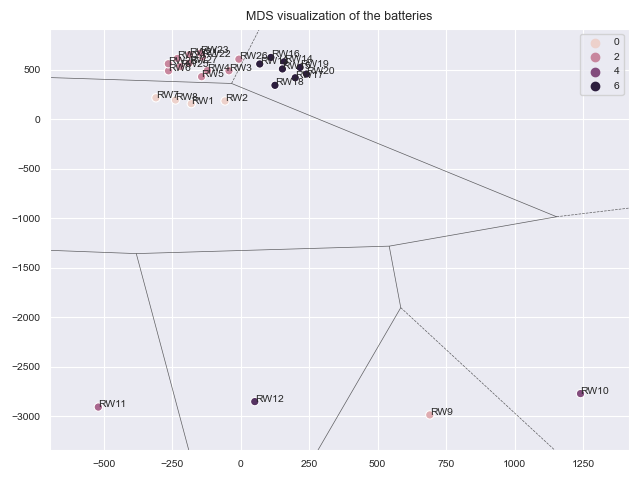

In [61]:
# Reduce the dimensionality of the distance matrix using MDS
mds = MDS(n_components=2)
mds_distances = mds.fit_transform(distances)


# Visualize the MDS distances with sns and the Voronoi diagram

# Add k-means centroids to the plot
k_means_labels, centroids = clustering(mds_distances, method=CLUSTERING)
# Plot the Voronoi diagram
vor = Voronoi(centroids)
voronoi_plot_2d(vor, alpha=0.5, show_vertices=False, show_points=False, line_colors='black', line_width=0.5, line_alpha=0.6)

sns.set_style('darkgrid')
plt.title('MDS visualization of the batteries')
# Compute the Voronoi tessellation of the MDS points
sns.scatterplot(x=mds_distances[:, 0], y=mds_distances[:, 1], hue=k_means_labels)


# add labels to the scatter plot
for i, bat in enumerate(dfs_dict.keys()):
    plt.annotate(bat, (mds_distances[i, 0], mds_distances[i, 1]))
    plt.rcParams.update({'font.size': 7.5})

plt.tight_layout()